# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

In [1]:
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)

2024-10-24 08:00:40.605460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 08:00:46.118018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 08:00:48.153840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 08:00:48.687379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 08:00:52.497595: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version:  2.17.0


## Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

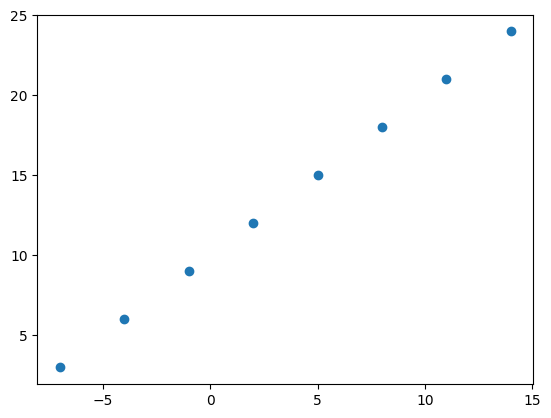

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

In [3]:
# The relationship we want to learn
y == X + 10

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Regression input shapes and output shapes

One of the most important concepts when working with neural networks are the input and output shapes.

The **input shape** is the shape of your data that goes into the model.

The **output shape** is the shape of your data you want to come out of your model.

These will differ depending on the problem you're working on.

Neural networks accept numbers and output numbers. These numbers are typically represented as tensors (or arrays).

Before, we created data using NumPy arrays, but we could do the same with tensors.

In [4]:
# Create a demo tensor for our housing price prediction problem
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])

house_info, house_price

I0000 00:00:1729728118.739795   37749 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729728123.414653   37749 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729728123.414706   37749 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729728123.426215   37749 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729728123.426263   37749 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [5]:
input_shape = X[0].shape
output_shape = y[0].shape

input_shape, output_shape # these are both scalars (no shape)

((), ())

Huh?

From this it seems our inputs and outputs have no shape?

How could that be?

It's because no matter what kind of data we pass to our model, it's always going to take as input and return as output some kind of tensor.

But in our case because of our dataset (only 2 small lists of numbers), we're looking at a special kind of tensor, more specifically a rank 0 tensor or a scalar.

In [6]:
# Let's take a look at the single examples invidually
X[0], y[0]

(-7.0, 3.0)

In [ ]:
# Turn our NumPy arrays into tensors with dtype float32
X = tf.cast(tf.constant(X), dtype=tf.float32)
y = tf.cast(tf.constant(y), dtype=tf.float32)
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In our case, we're trying to build a model to predict the pattern between `X[0]` equalling `-7.0` and `y[0]` equalling `3.0`.

So now we get our answer, we're trying to use 1 `X` value to predict 1 `y` value.

You might be thinking, "this seems pretty complicated for just predicting a straight line...".

And you'd be right.

But the concepts we're covering here, the concepts of input and output shapes to a model are fundamental. 

In fact, they're probably two of the things you'll spend the most time on when you work with neural networks: **making sure your input and outputs are in the correct shape**.

## Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).

2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
    - Loss: How wrong your model's predictions are compared to the truth labels (minimise this)
    - Optimizer: How your model should update it's internal patterns to better it's predictions.
    - Metrics: Human interpretable values for how well your model is doing.

3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).
   - Epochs: How many times the model will go through all of the training examples.

4. **Evaluate a model** - Evaluate the model on the test data (how reliable are our model's predictions?)


Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

In [8]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model using the Sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=5)

Epoch 1/5


I0000 00:00:1729728125.239651   38930 service.cc:146] XLA service 0x7f568c016e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729728125.239800   38930 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-10-24 08:02:05.887391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 08:02:07.283304: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 15.3139 - mae: 15.3139
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 15.0327 - mae: 15.0327
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.8268 - mae: 14.8268
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.6943 - mae: 14.6943
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 14.5618 - mae: 14.5618


I0000 00:00:1729728128.534690   38930 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
# Check out X and y again
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [10]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1))
y_pred  # the correct answer is 27

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[-4.687232]], dtype=float32)

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [11]:
# Let's rebuild our model

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=100) # This time we'll train for longer

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 9.5727 - mae: 9.5727
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.4402 - mae: 9.4402
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.3077 - mae: 9.3077
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.1752 - mae: 9.1752
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0427 - mae: 9.0427
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.9102 - mae: 8.9102
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.7777 - mae: 8.7777
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.6452 - mae: 8.6452
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.5127 - mae: 8.5127
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.3802 - mae: 8.3802
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.2477 - mae: 8.2477
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.1152 - mae: 8.1152
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/st

In [12]:
# Check out X and y again
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [13]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1)) # the correct answer is 27
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[29.982769]], dtype=float32)

In [14]:
# Let's rebuild our model again

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50), # add 50 dense neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              # Adam is another optimizer like SGD but usually performs better, and changes the learning rate as it goes
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - loss: 12.1102 - mae: 12.1102
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 11.4366 - mae: 11.4366
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10.7497 - mae: 10.7497
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 10.0481 - mae: 10.0481
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 9.3297 - mae: 9.3297
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5914 - mae: 8.5914
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.8306 - mae: 7.8306
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.0450 - mae: 7.0450
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.8521 - mae: 6.8521
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.2788 - mae: 7.2788
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.6087 - mae: 7.6087
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.8256 - mae: 7.8256
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [15]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1)) # the correct answer is 27
y_pred # the prediction is much closer to the correct answer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


array([[26.398333]], dtype=float32)

## Evaluating a model 

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

### Visualize, visualize, visualize

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize." 

This is because you're probably better looking at something (doing) than you are thinking about something.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

But first, we'll create a little bit of a bigger dataset and a new model we can use (it'll be the same as before, but the more practice the better).


In [16]:
# Make a biger dataset
X = tf.range(-100, 100, 4)
X

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96], dtype=int32)>

In [17]:
# Make labels for the dataset
y = X + 10
y

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

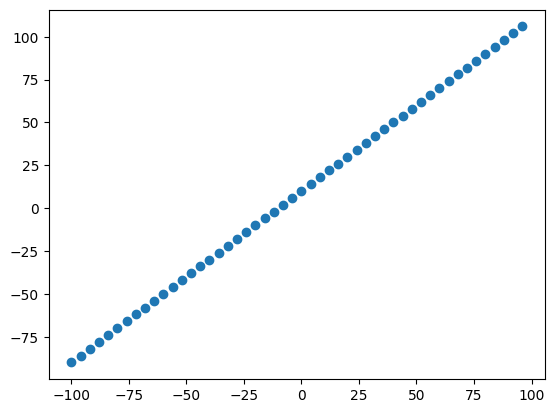

In [18]:
# Visualize the data
import matplotlib.pyplot as plt

plt.scatter(X, y)

### Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you take before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [19]:
# Check the length of how many sample we have
len(X), len(y)

(50, 50)

In [20]:
# Split the data into train and test sets
X_train = X[:40] # first 40 are training samples (80% of the data)
y_train = y[:40]

X_test = X[40:] # last 10 are testing samples (20% of the data)
y_test = y[40:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

#### Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.

Let's plot it with some nice colours to differentiate what's what.

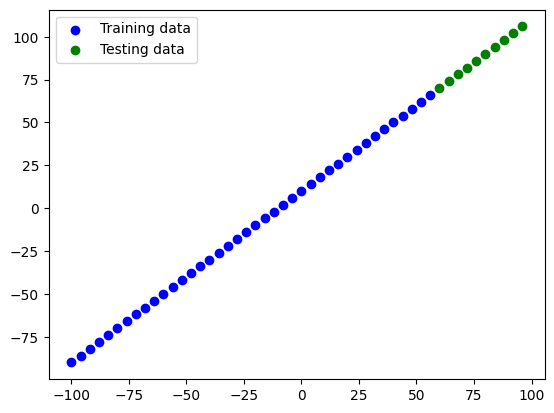

In [21]:
# Plot training data in blue
plt.scatter(X_train, y_train, c="b", label="Training data")
# Plot test data in green
plt.scatter(X_test, y_test, c="g", label="Testing data")
# Show the legend
plt.legend()

plt.show()

### Build and Visualizing the model

In [22]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])


/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


After you've built a model, you might want to take a look at it (especially if you haven't built many before).

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

> 🔑 **Note:** Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

> 📖 **Resource:** For a more in-depth overview of the trainable parameters within a layer, check out [MIT's introduction to deep learning video](https://youtu.be/njKP3FqW3Sk).

#### 🛠 **Exercise:** Try playing around with the number of hidden units in the `Dense` layer (e.g. `Dense(2)`, `Dense(3)`). 

How does this change the Total/Trainable params? Investigate what's causing the change.

In [24]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1], name="input_layer"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model")

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

model.summary()

# The total/trainable parameters is calculated as follows:
# (input_shape * units) + units
# (1 * 2) + 2 = 4
# (3 * 2) + 2 = 8

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Let's fit our model to the training data.
model.fit(X_train, y_train, epochs=100, verbose=0)

In [26]:
# Check the model summary
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (28.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

#### tf.keras.utils.plot_model()

Alongside summary, you can also view a 2D plot of the model using [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

In our case, the model we used only has an input and an output but visualizing more complicated models can be very helpful for debugging.

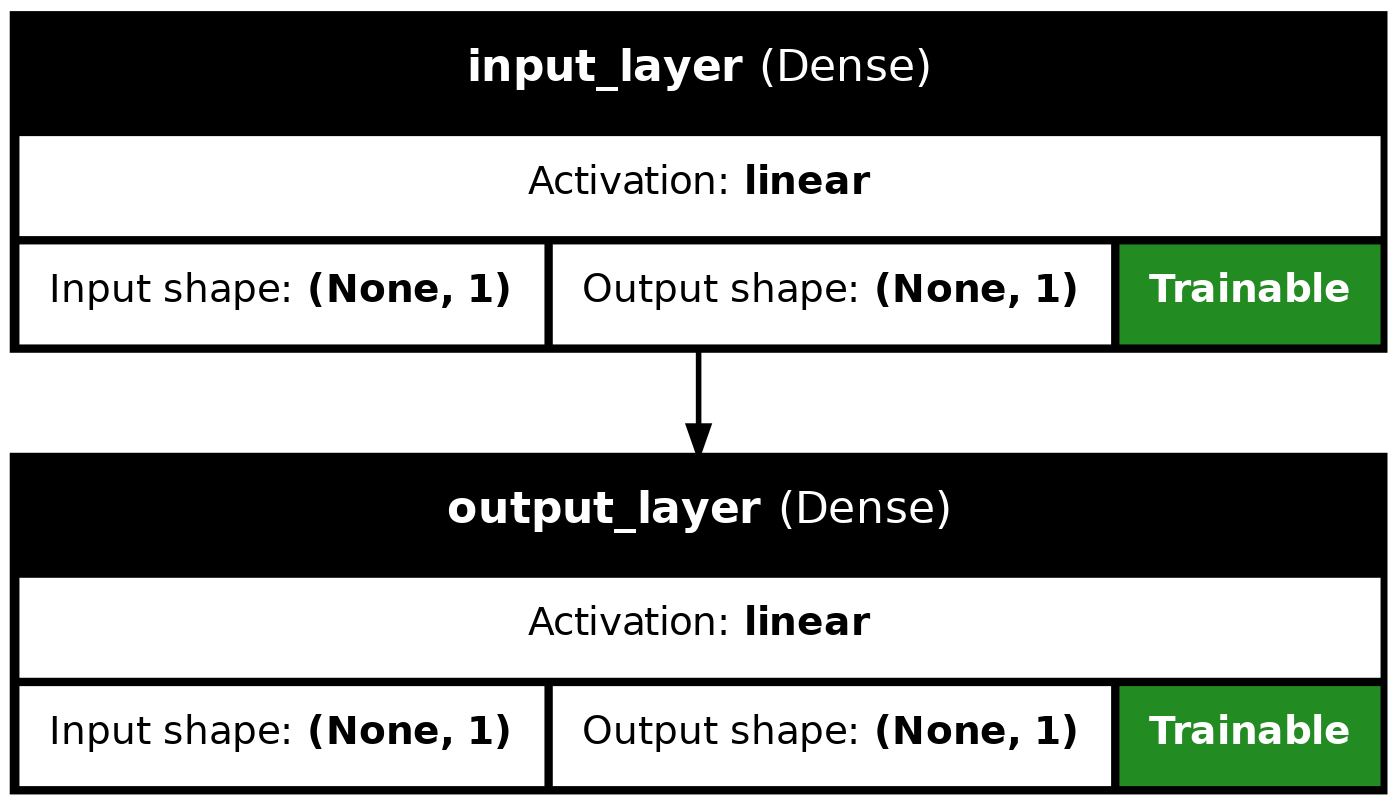

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)

### Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [28]:
# Make predictions
y_preds = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [29]:
# View the predictions
y_preds

array([[43.766777],
       [46.576157],
       [49.385536],
       [52.194916],
       [55.00429 ],
       [57.813667],
       [60.623047],
       [63.432426],
       [66.241806],
       [69.051186]], dtype=float32)

In [30]:
y_test

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

Okay, we get a list of numbers but how do these compare to the ground truth labels?

Let's build a plotting function to find out.

> 🔑 **Note:** If you think you're going to be visualizing something a lot, it's a good idea to functionize it so you can use it later.

In [31]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

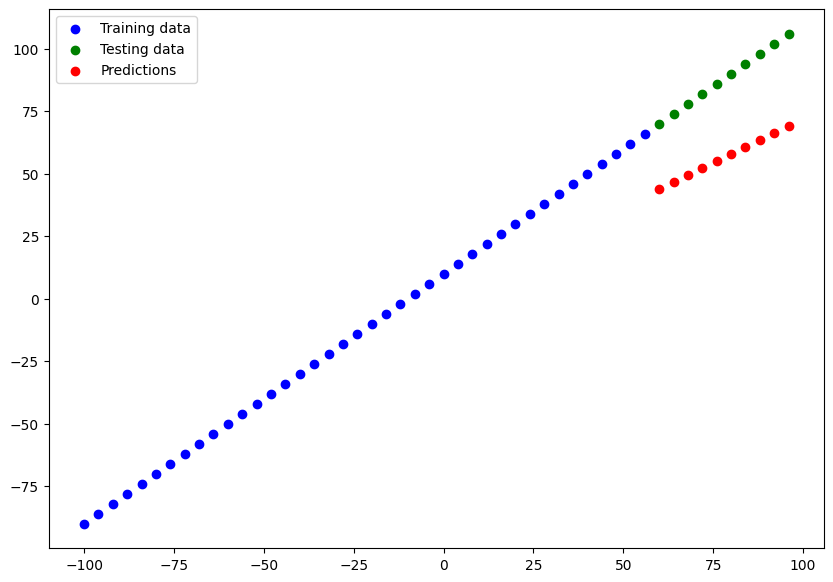

In [32]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

## Evaluating predictions

Alongisde visualizations, evaulation metrics are your alternative best option for evaluating your model.

Depending on the problem you're working on, different models have different evaluation metrics. 

Two of the main metrics used for regression problems are:
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).

The lower each of these values, the better.

You can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) which will return the loss of the model as well as any metrics setup during the compile step.

In [33]:
# Evaulate the model on the test set

"""
# * note: it will show MAE because that's what we compiled the model with
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])
"""

model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 31.5910 - mae: 31.5910


[31.591018676757812, 31.591018676757812]

In [34]:
# note: y_pred is an array with shape (10, 1) and y_test is a tensor with shape (10,)
y_preds, y_test

(array([[43.766777],
        [46.576157],
        [49.385536],
        [52.194916],
        [55.00429 ],
        [57.813667],
        [60.623047],
        [63.432426],
        [66.241806],
        [69.051186]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>)

We can use `tf.metrics.MAE()` or `tf.keras.losses.MAE()`, they are the same

In [35]:
# Calculate the mean absolute error

# we need to flatten y_pred to the same shape as y_test
mae = tf.keras.losses.MAE(y_test, tf.squeeze(y_preds))
mae

<tf.Tensor: shape=(), dtype=float32, numpy=31.591019>

In [36]:
# Calculate the MSE
mse = tf.metrics.MSE(y_true=y_test, y_pred=y_preds.squeeze())
mse

<tf.Tensor: shape=(), dtype=float32, numpy=1009.6875>

In [37]:
# Make functions to reuse MAE and MSE
def calc_mae(y_true, y_pred):
  return tf.metrics.MAE(y_true, tf.squeeze(y_pred))

def calc_mse(y_true, y_pred):
  return tf.metrics.MSE(y_true, tf.squeeze(y_pred))

In [38]:
mae = calc_mae(y_test, y_preds)
mse = calc_mse(y_test, y_preds)

mae, mse

(<tf.Tensor: shape=(), dtype=float32, numpy=31.591019>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1009.6875>)

### Running experiments to improve a model

After seeing the evaluation metrics and the predictions your model makes, it's likely you'll want to improve it.

Again, there are many different ways you can do this, but 3 of the main ones are:
1. **Get more data** - get more examples for your model to train on (more opportunities to learn patterns).
2. **Make your model larger (use a more complex model)** - this might come in the form of more layers or more hidden units in each layer.
3. **Train for longer** - give your model more of a chance to find the patterns in the data.

Since we created our dataset, we could easily make more data but this isn't always the case when you're working with real-world datasets.

So let's take a look at how we can improve our model using 2 and 3.

To do so, we'll build 3 models and compare their results:
1. `model_1` - same as original model, 1 layer, trained for 100 epochs.
2. `model_2` - 2 layers, trained for 100 epochs.
3. `model_3` - 2 layers, trained for 500 epochs.

**Build `model_1`**

In [39]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"])

# 3. Fit the model
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 90.1210 - mae: 90.1210
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 54.9528 - mae: 54.9528
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.8107 - mae: 20.8107
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.1060 - mae: 8.1060
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.7433 - mae: 10.7433
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.2438 - mae: 10.2438
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 12.0046 - mae: 12.0046
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12.7349 - mae: 12.7349
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2141 - mae: 8.2141
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8822 - mae: 8.8822
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.9332 - mae: 7.9332
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5623 - mae: 9.5623
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


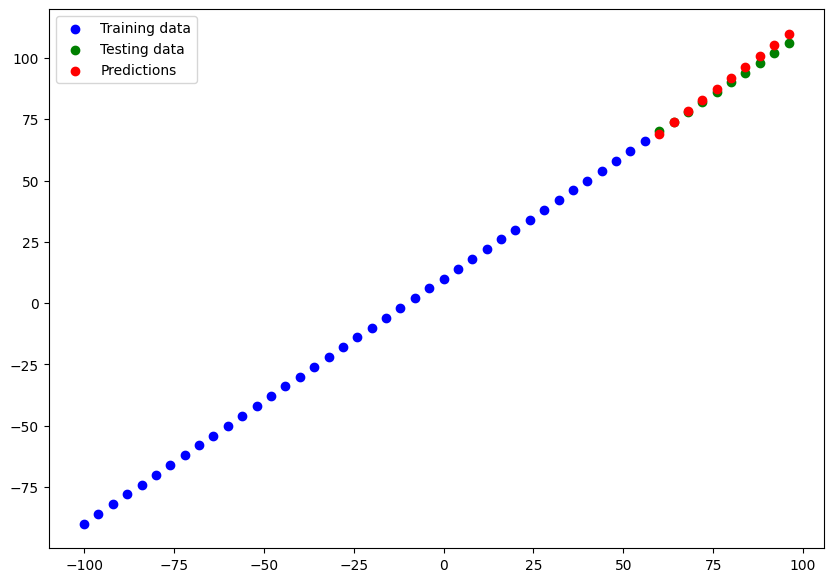

In [40]:
# Make and plot predictions for model_1
y_preds_1 = model_1.predict(tf.expand_dims(X_test, axis=-1))

plot_predictions(predictions=y_preds_1)

In [41]:
# Calculate model_1 evaluation metrics
mae_1 = calc_mae(y_test, y_preds_1)
mse_1 = calc_mse(y_test, y_preds_1)

mae_1, mse_1

(<tf.Tensor: shape=(), dtype=float32, numpy=1.7384186>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.512773>)

**Build `model_2`**

This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [42]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mse"])

# 3. Fit the model
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 56.2513 - mse: 4675.4829
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 35.2946 - mse: 1816.9673
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 11.7780 - mse: 162.2175
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 13.3701 - mse: 228.2885
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16.5206 - mse: 395.7887
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.9029 - mse: 134.0880
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.0882 - mse: 168.2250 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.2899 - mse: 231.9041
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 15.9814 - mse: 367.8678
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.3510 - mse: 118.9319
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.3223 - mse: 120.8311
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.3400 - mse: 142.4688
Epoch 13/10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


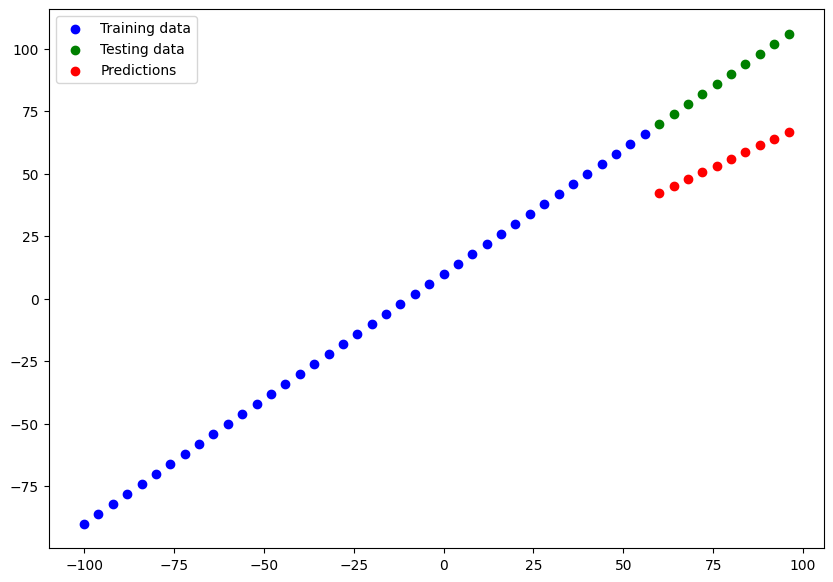

In [43]:
# Make predictions and plot them
y_preds_2 = model_2.predict(tf.expand_dims(X_test, axis=-1))
plot_predictions(predictions=y_preds_2)

In [44]:
# Calculate model_2 evaluation metrics
mae_2 = calc_mae(y_test, y_preds_2)
mse_2 = calc_mse(y_test, y_preds_2)

mae_2, mse_2

(<tf.Tensor: shape=(), dtype=float32, numpy=33.384666>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1128.5017>)

**Build `model_3`**

For our 3rd model, we'll keep everything the same as `model_2` except this time we'll train for longer (500 epochs instead of 100).

This will give our model more of a chance to learn the patterns in the data.

In [45]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_2
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model (this time for 500 epochs, not 100)
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=0) # set verbose to 0 for less output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


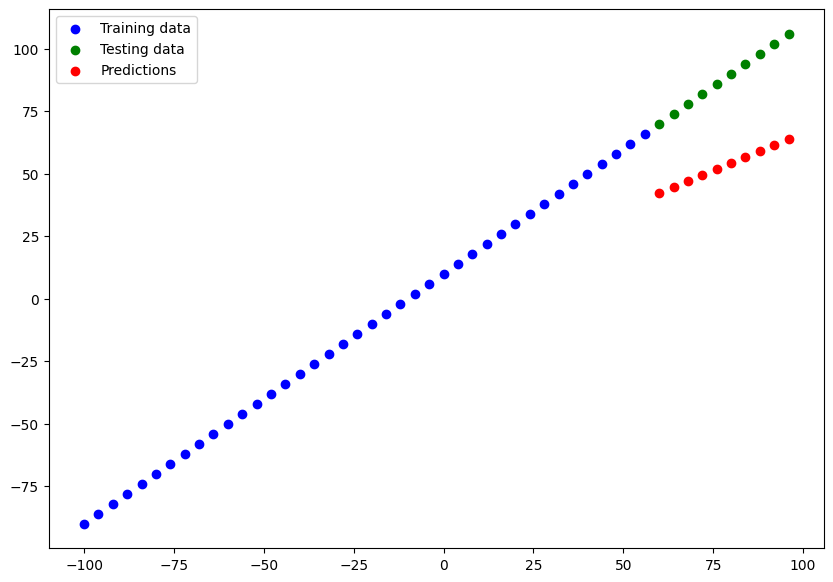

In [46]:
# Make and plot predictions for model_3
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

In [47]:
# Calculate model_3 metrics
mae_3 = calc_mae(y_test, y_preds_3)
mse_3 = calc_mse(y_test, y_preds_3)
mae_3, mse_3

(<tf.Tensor: shape=(), dtype=float32, numpy=34.724358>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1226.721>)

Strange, we trained for longer but our model performed worse?

As it turns out, our model might've trained too long and has thus resulted in worse results (we'll see ways to prevent training for too long later on).

## Comparing results

Now we've got results for 3 similar but slightly different results, let's compare them.

In [48]:
import pandas as pd

model_results = [["model_1", mae_1.numpy(), mse_1.numpy()],
                             ["model_2", mae_2.numpy(), mse_2.numpy()],
                             ["model_3", mae_3.numpy(), mse_3.numpy()]]

results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
results

,model,mae,mse
0,model_1,1.738419,4.512773
1,model_2,33.384666,1128.501709
2,model_3,34.724358,1226.720947


From our experiments, it looks like `model_1` performed the best.

And now, you might be thinking, "wow, comparing models is tedious..." and it definitely can be, we've only compared 3 models here. 

But this is part of what machine learning modelling is about, trying many different combinations of models and seeing which performs best.

Each model you build is a small experiment. 

> 🔑 **Note:** One of your main goals should be to minimize the time between your experiments. The more experiments you do, the more things you'll figure out which don't work and in turn, get closer to figuring out what does work. Remember the machine learning practitioner's motto: "experiment, experiment, experiment".

Another thing you'll also find is what you thought may work (such as training a model for longer) may not always work and the exact opposite is also often the case.

## Tracking your experiments

One really good habit to get into is tracking your modelling experiments to see which perform better than others.

We've done a simple version of this above (keeping the results in different variables).

> 📖 **Resource:** But as you build more models, you'll want to look into using tools such as:
* [**TensorBoard**](https://tensorboard.dev/) - a component of the TensorFlow library to help track modelling experiments (we'll see this later).
* [**Weights & Biases**](https://www.wandb.com/) - a tool for tracking all kinds of machine learning experiments (the good news for Weights & Biases is it plugs into TensorBoard).

## Saving a model

Once you've trained a model and found one which performs to your liking, you'll probably want to save it for use elsewhere (like a web application or mobile device).

You can save a TensorFlow/Keras model using [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

There are two ways to save a model in TensorFlow:
1. The [keras format](https://www.tensorflow.org/tutorials/keras/save_and_load#new_high-level_keras_format).
2. The [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format).

The main difference between the two is the SavedModel is automatically able to save custom objects (such as special layers) without additional modifications when loading the model back in.

Which one should you use?

It depends on your situation but the SavedModel format will suffice most of the time.

Both methods use the same method call.

In [53]:
# Save model using the Keras format
!mkdir -p saved_models

model_1.save("saved_models/model_1.keras")

In [54]:
# Save model using the HDF5 format

model_1.save("saved_models/model_1.h5")

## Loading a model

We can load a saved model using the [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) method.

Loading a model for the different formats (SavedModel and HDF5) is the same (as long as the pathnames to the particular formats are correct).

In [56]:
# Load in a model using the Keras format
loaded_model_1 = tf.keras.models.load_model("saved_models/model_1.keras")

# check the model summary
loaded_model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (20.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


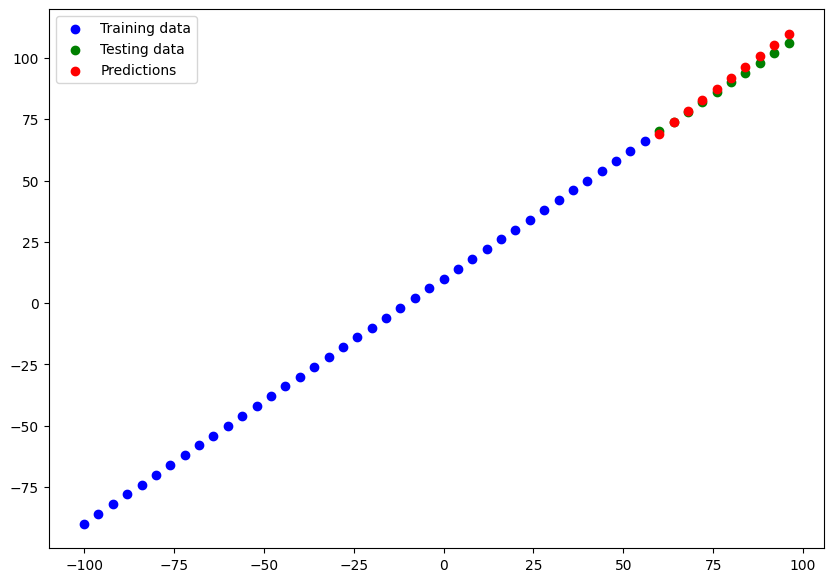

In [57]:
# Make and plot predictions with the loaded model
loaded_model_1_preds = loaded_model_1.predict(X_test)

plot_predictions(predictions=loaded_model_1_preds)

In [58]:
# Load in a model using the HDF5 format
loaded_model_2 = tf.keras.models.load_model("saved_models/model_1.h5")

# Check the loaded model summary
loaded_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (20.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


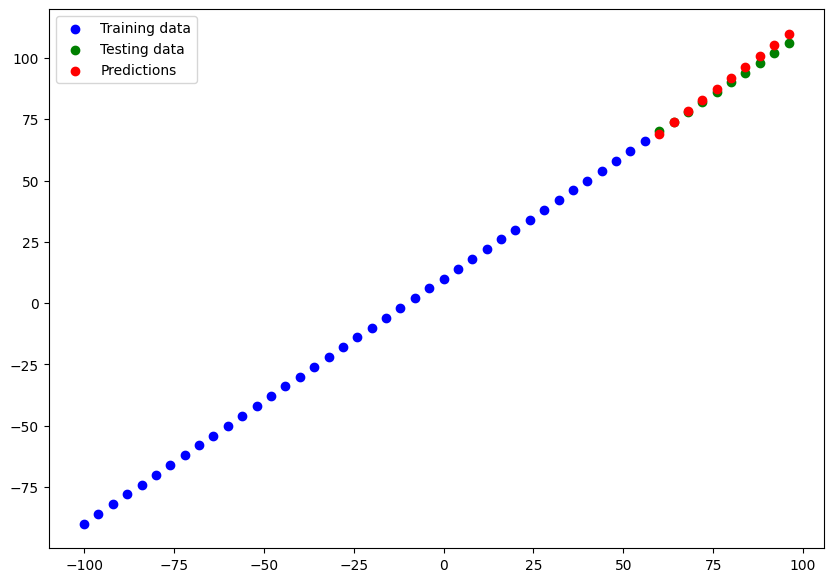

In [59]:
# Make and plot predictions with the loaded HDF5 model
loaded_model_2_preds = loaded_model_2.predict(X_test)

plot_predictions(predictions=loaded_model_2_preds)